
# Investigate the "coming rate" at medical appointments in Bresil

## Table of Contents
<ul>
<li><a href="#intro">1. Introduction</a></li><br>
<li><a href="#wrangling">2. Data Wrangling</a></li>
&nbsp;&nbsp;&nbsp;&nbsp;[2a. Acquire Data](#acquire_data)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2b. General Properties](#general_properties)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2b. Data Cleaning and creation of new columns](#data_cleaning) <br><br>
<li><a href="#eda">Exploratory Data Analysis</a></li>
&nbsp;&nbsp;&nbsp;&nbsp;[Quick summary of statistics according to No_show](#quick_stat)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Helper function](#helper) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Q1. If the patient has a chronic disease (Diabetes, Hypertension, Alcoholism or Handicap), does it influence the coming rate?](#severe_disease)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Q2. Does the age of patient affect the coming rate?](#age)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Q3. Does the period between the appointment date and the scheduled day make a difference in the coming rate?](#period)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Q4. Does the day of the meeting make a difference?](#day)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Q5. Does reminding the appointment with a text make a higher rate of coming?](#text)<br> <br>
<li><a href="#conclusions">Conclusions</a></li> <br>
    <li><a href="#references">References</a></li>
</ul>

<a id='intro'></a>
## Introduction
Do all patients show up at medical appointment? If not, what could be the reason? <br>
This project analyses a __[database](https://www.kaggle.com/joniarroba/noshowappointments)__ of medical appointments and parameters on the patient and the appointment details. The most important parameter is if the patient shows-up or not to the appointment. The data are during the month of June 2016.
<br><br>
The main question is: <br>
What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment? <br><br>
For this project, we will focus more precisely on the questions below:
- **If the patient has a chronic disease (Diabetes, Hypertension, Alcoholism or Handicap), does it influence the coming rate?**
- **Does the age of patient affect the coming rate?**
- **Does the period between the scheduled day and the appointment make a difference in the coming rate?**
- **Does the day of the appointment make a difference?**
- **Does reminding the appointment with a text make a higher rate of coming?**

In [1]:
# import packages used in this project
import pandas as pd
import numpy as np
import datetime
import seaborn as sbs
import matplotlib.pyplot as plt
import seaborn as sns

# settings for graphics
%matplotlib inline
sns.set_style("whitegrid")

<a id='wrangling'></a>
## Data Wrangling

<a id='acquire_data'></a>
### Acquire data
We start by acquiring the dataset into Pandas DataFrame.

In [2]:
df = pd.read_csv('./original_data/no_show_appointments.csv')

<a id='general_properties'></a>
### General Properties
**Which features are available in the dataset and their type?**<br>

In [3]:
# Inspection of data types
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

In [4]:
#NOTE: the name No-show is not the best writing and could cause problem later on. The column will be renamed No_show.
df.rename(columns={'No-show': 'No_show'}, inplace=True) 

In [5]:
#get the unique values in different columns
print('Gender:',df.Gender.unique()) 
print('Age:',sorted(df.Age.unique()))
print('Scholarship:',df.Scholarship.unique()) 
print('Hipertension:',df.Hipertension.unique())
print('Diabetes:',df.Diabetes.unique())
print('Alcoholism:',df.SMS_received.unique())
print('Handcap:',df.Handcap.unique()) 
print('SMS_received:',df.SMS_received.unique())
print('No_show:',df.No_show.unique())

Gender: ['F' 'M']
Age: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]
Scholarship: [0 1]
Hipertension: [1 0]
Diabetes: [0 1]
Alcoholism: [0 1]
Handcap: [0 1 2 3 4]
SMS_received: [0 1]
No_show: ['No' 'Yes']


In [6]:
# Preview the data
df.head()

PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No_show  
0         0           0        0             0      No  
1         0           0        0             0      No  
2         0           0        0             0      No  
3         0           0        0             0      No  
4         1           0        0             0      No

 _Structure of the database_ :<br>
**PatientId** = Identification of a patient (float).<br>
**AppointmentID** = Identification of each appointment (int).<br>
**Gender** = Male or Female: string ['F' 'M']. <br>
**ScheduledDay** = Day when the appointment is scheduled, this is before the appointment of course (string). <br>
**AppointmentDay** = Day of the actual appointment (string). <br>
**Age** = How old is the patient: int from -1 à 115. <br>
**Neighbourhood** = indicates the location of the hospital where the appointment takes place (string).<br>
**Scholarship** = True of False: int [0 1].<br>
**Hipertension** = True or False: int [0 1].<br>
**Diabetes** = True or False: int [0 1].  <br>
**Alcoholism** = True or False: int [0 1].<br>
**Handcap** = level of handicap: int [0 1 2 3 4].<br>
**SMS_received** = True or False: int [0 1]. <br>
**No_show** = 'No' or 'Yes': string ['No' 'Yes']. Note: 'No’ if the patient showed up to their appointment, and ‘Yes’ if he did not show up).<br>


**Which features contain blank, null or empty values?**

In [7]:
# Looking for missing or possibly errant data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No_show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In the dataset, there are 14 columns, 110527 different appointments (rows) and none of the features have missing values.

** Are there duplicated rows?**

In [8]:
# gives the sum of the duplicated rows
sum(df.duplicated()) 

0

As expected, none of the rows are duplicated.

** Are there missing values?** 

In [9]:
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No_show           0
dtype: int64

There are no NaN values in the dataset.

**What is the distribution of numerical features?**<br>

In [10]:
df.describe()

PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205       0.297675   
min    3.921784e+04   5.030230e+06      -1.000000       0.000000   
25%    4.172614e+12   5.640286e+06      18.000000       0.000000   
50%    3.173184e+13   5.680573e+06      37.000000       0.000000   
75%    9.439172e+13   5.725524e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hipertension       Diabetes     Alcoholism        Handcap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       4.000000   

        SMS_received  
count  110527.000000  
mean        0.321026  
std         0.466873  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

- The average age is 37 years old. There is an error with the minimum age of -1, which will be corrected later on.
- Scholarship is a categorical feature with 0 and 1 values. About 10% of all the patients have a scholarship.
- Patients with chronic disease represents respectively 20%, 7%, 3% and 2% for Hypertension, Diabetes, Alcoholism, Handicap.
- Only 32% of the patients where notified by SMS.
- The number of SMS received is not specified.

**What is the distribution of categorical features?**<br>

In [11]:
df.describe(include=['O'])

Gender          ScheduledDay        AppointmentDay   Neighbourhood  \
count   110527                110527                110527          110527   
unique       2                103549                    27              81   
top          F  2016-05-06T07:09:54Z  2016-06-06T00:00:00Z  JARDIM CAMBURI   
freq     71840                    24                  4692            7717   

       No_show  
count   110527  
unique       2  
top         No  
freq     88208

- The patients are mostly women with 65% (freq=71840/count=110527).
- The day with the most appointment is the 6th of June 2016.
- In the database, 27 hospitals are represent (Neighbourhood) and the hospital JARDIM CAMBURI is the one with the most of visit.
- Patients are coming to appointment in 80% of all cases ('No’ if the patient showed up to their appointment, and ‘Yes’ if he did not show up).

<a id='data_cleaning'></a>
### Data Cleaning and creation of new columns

**Change column name** <br>
For my comfort, I choose to change the column names of `Handcap` and `Hipertension` by respectively `Handicap` and `Hypertension`.

In [12]:
#change of column names
df.rename(columns={'Handcap': 'Handicap', 'Hipertension': 'Hypertension'}, inplace=True) 
df.head(1)

PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   

         AppointmentDay  Age    Neighbourhood  Scholarship  Hypertension  \
0  2016-04-29T00:00:00Z   62  JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handicap  SMS_received No_show  
0         0           0         0             0      No

**Data Cleaning** <br>
1\. For the cleaning step, I have noticed that the range of `age` is from -1 to 115 years old. Thus the first step of cleaning is to keep only rows where `age` is higher than 0. 

In [13]:
#First step keeping rows where age > 0
df = df[df.Age >= 0]

#verification that now every age is over 0.
df['Age'].describe()

count    110526.000000
mean         37.089219
std          23.110026
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

2\. The second step of cleaning is to change the data type of `ScheduledDay` and `AppointmentDay` from string to dates.

In [14]:
#change of data types
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df.dtypes

PatientId                float64
AppointmentID              int64
Gender                    object
ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood             object
Scholarship                int64
Hypertension               int64
Diabetes                   int64
Alcoholism                 int64
Handicap                   int64
SMS_received               int64
No_show                   object
dtype: object

**Update of columns** <br>
1\. I have decided to answer to some questions and I will not use the whole dataset. For this reason, I will erase some columns. I will not work on the difference of coming rate depending of the sex because the set of patients are mostly women. However I will not erase this column, which might be very important for patients. <br>
I will not work with the parameters of `Neighbourhood` and `Scholarship` so I am not keeping these columns. 

In [15]:
#All the columns to keep are not next to each other so creation of a array with Numpy
columns = np.r_[1:6, 8:14] 

#selection of the new columns
df = df.iloc[:, columns]
df.head(1)

AppointmentID Gender        ScheduledDay AppointmentDay  Age  Hypertension  \
0        5642903      F 2016-04-29 18:38:08     2016-04-29   62             1   

   Diabetes  Alcoholism  Handicap  SMS_received No_show  
0         0           0         0             0      No

**Creation of new columns** <br><br> 1. I will work on the period between the `ScheduledDay`(when the appointment is scheduled) and `AppointmentDay` (when the appointment is happening) and  I will calculate the period between these two dates (`Waiting_period`).

In [16]:
#creation of a column 'Waiting_period' calculationg the period between the 2 dates in days
df['waiting_period'] = (df['AppointmentDay'] - df['ScheduledDay'] + datetime.timedelta(days=1)).dt.days
#if both day are the same the result is 0
df['waiting_period'].describe()

count    110526.000000
mean         10.183794
std          15.255034
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: waiting_period, dtype: float64

We observe on this table that some `waiting_period` are lower than 0 (same day) and it comes from a error when entering the data. We can observe these rows and delete them.

In [17]:
#observation of rows with not normal waiting time
not_normal = df.query('waiting_period < 0')
not_normal

AppointmentID Gender        ScheduledDay AppointmentDay  Age  \
27033        5679978      M 2016-05-10 10:51:53     2016-05-09   38   
55226        5715660      F 2016-05-18 14:50:41     2016-05-17   19   
64175        5664962      F 2016-05-05 13:43:58     2016-05-04   22   
71533        5686628      F 2016-05-11 13:49:20     2016-05-05   81   
72362        5655637      M 2016-05-04 06:50:57     2016-05-03    7   

       Hypertension  Diabetes  Alcoholism  Handicap  SMS_received No_show  \
27033             0         0           0         1             0     Yes   
55226             0         0           0         1             0     Yes   
64175             0         0           0         0             0     Yes   
71533             0         0           0         0             0     Yes   
72362             0         0           0         0             0     Yes   

       waiting_period  
27033              -1  
55226              -1  
64175              -1  
71533              -6  
72362              -1

In [18]:
#delete not_normal rows
index_not_normal = not_normal.index.values
df.drop(index_not_normal, axis=0, inplace=True)

#check if the not_normal_values disappeared
df['waiting_period'].describe()

count    110521.000000
mean         10.184345
std          15.255153
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: waiting_period, dtype: float64

The not_normal_values have been erased.

2\. For better visualization of the age, I create a new columns where the ages are in a bin of 2 years. From previously we know that the maximum age is 115.

In [19]:
#creation of array for categories of age
#patients from 0 to 1 included will be in the group 0, from 2 to 3 in the group 2

bin_edges = np.arange(-1, 117, 2) #(min, max, step)
bin_names = np.arange(0, 115, 2)

#create the new column with bin edges and names
df['age_bin'] = pd.cut(df['Age'], bin_edges, labels=bin_names)
df.head(1)

AppointmentID Gender        ScheduledDay AppointmentDay  Age  Hypertension  \
0        5642903      F 2016-04-29 18:38:08     2016-04-29   62             1   

   Diabetes  Alcoholism  Handicap  SMS_received No_show  waiting_period  \
0         0           0         0             0      No               0   

  age_bin  
0      62

3\.To answer to the question concerning the day of the week, I need to create a new column `day_of_week`, where the day of the week is extracted from `ScheduledDay`.

In [20]:
#Extract the day of the week
df['day_of_week'] = df['AppointmentDay'].dt.weekday_name
df.head(1)

AppointmentID Gender        ScheduledDay AppointmentDay  Age  Hypertension  \
0        5642903      F 2016-04-29 18:38:08     2016-04-29   62             1   

   Diabetes  Alcoholism  Handicap  SMS_received No_show  waiting_period  \
0         0           0         0             0      No               0   

  age_bin day_of_week  
0      62      Friday

4\. After the creation of these new columns, `AppointmentDay` and  `ScheduledDay` are no more necessary and will be erased with the drop function.

In [21]:
df.drop(['ScheduledDay', 'AppointmentDay'], axis=1, inplace=True)
df.head(1)

AppointmentID Gender  Age  Hypertension  Diabetes  Alcoholism  Handicap  \
0        5642903      F   62             1         0           0         0   

   SMS_received No_show  waiting_period age_bin day_of_week  
0             0      No               0      62      Friday

In [22]:
df['day_of_week'].unique()

array(['Friday', 'Tuesday', 'Monday', 'Wednesday', 'Thursday', 'Saturday'], dtype=object)

Note: No appointment happens on Sunday.

In [23]:
#save the new dataset into noshow_edited file
df.to_csv('noshowedited.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis
To be sure to not modify the original data, the dataframe will restart from the new file.

In [24]:
df = pd.read_csv('noshowedited.csv')
df.head(1)

AppointmentID Gender  Age  Hypertension  Diabetes  Alcoholism  Handicap  \
0        5642903      F   62             1         0           0         0   

   SMS_received No_show  waiting_period  age_bin day_of_week  
0             0      No               0       62      Friday

<a id='quick_stat'></a>
### Quick summary of statistics according to No_show

To have a quick idea about the relation between `No_show` and the other variables we could apply a `group by` function.

In [25]:
df.groupby('No_show').mean()

AppointmentID        Age  Hypertension  Diabetes  Alcoholism  \
No_show                                                                 
No        5.681135e+06  37.790504      0.204394  0.073838    0.030417   
Yes       5.652252e+06  34.317872      0.169042  0.064085    0.030340   

         Handicap  SMS_received  waiting_period    age_bin  
No_show                                                     
No       0.022742      0.291337        8.754759  37.302867  
Yes      0.020212      0.438469       15.835484  33.824326

At first look, we could say that the coming rate (the No or Yes No-show) does not depend from the age, neither from a chronic disease, nor the day of the week. However it seems that the coming rate might depend on the waiting period and the notification by SMS.<br>
Further investigations are done below.

<a id='helper'></a>
### Helper function

**`come_prop`**<br>
I have created a helper function. This function **`come_prop` returns the probability of 'showing up' according to the column indicated**. It assumes that 'No' at `No_show` means that the patient showed up at the appointment.

In [26]:
def come_prop(col_name):
    '''helper function: This function takes as input a column name and returns the proportions of showing up in each
    categories of this column'''
    #calcul of proportion to show up 
    count = df.groupby(['No_show', col_name]).count()['AppointmentID']
    total = df.groupby(col_name).count()['AppointmentID']
    come_proportion = count['No'] / total
    return come_proportion

<a id='severe_disease'></a>
### Q1: If the patient has a chronic disease (Diabetes, Hypertension, Alcoholism or Handicap), does it influence the coming rate?
The first step is to get the proportion of patients showing up depending on the chronic diseases with the helper function. Then these data will be plotted into bars. For better understanding, `Diabetes`, `Hypertension` and `Alcoholism` are plot together into a subplot and `Handicap` into another subplot.

In [27]:
#get the proportion for showing up for the 3 first chronic diseases.
diabetes_prop = come_prop('Diabetes')
hypertension_prop = come_prop('Hypertension')
alcoholism_prop = come_prop('Alcoholism')
#make a dataframe from tuples
index =['diabetes', 'hypertension', 'alcohol']
df_disease = pd.DataFrame.from_records((diabetes_prop, hypertension_prop, alcoholism_prop), index=index)
df_disease

Alcoholism           0         1
diabetes      0.796409  0.819967
hypertension  0.791005  0.826980
alcohol       0.798089  0.798512

In [28]:
#get the proportion for showing up for handicap
handicap_prop = come_prop('Handicap')
handicap_prop

Handicap
0    0.797667
1    0.821569
2    0.797814
3    0.769231
4    0.666667
Name: AppointmentID, dtype: float64

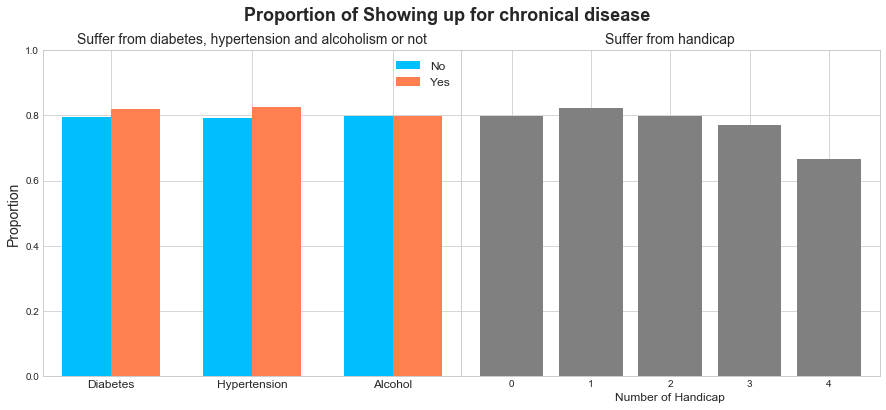

In [29]:
#plotting the 2 groups together
fig = plt.figure(figsize=(15,6))

#PLOT 1: diabetes, hypertension, alcoholism
ax1 = fig.add_subplot(1,2,1)

#set x
ind = np.arange(3)  # the x locations for the groups
width = 0.35       # the width of the bars
#set the bars
ax1.bar(ind, df_disease[0], width, color='deepskyblue', label='No')
ax1.bar(ind + width, df_disease[1], width, color='coral', label='Yes')
#limits x axis
ax1.set_ylim([0, 1])
#set titles
ax1.set_title('Suffer from diabetes, hypertension and alcoholism or not', fontsize= 14)
ax1.set_xlabel('')
ax1.set_ylabel('Proportion', fontsize=14)
#set x ticks
locations = ind + width / 2  # xtick locations
labels = ['Diabetes', 'Hypertension', 'Alcohol']  # xtick labels
ax1.set_xticks(locations)
ax1.set_xticklabels(labels, fontsize=12)
ax1.legend(fontsize=12)

#PLOT 2: Handicap with shared y axis
ax2 = fig.add_subplot(1,2,2, sharey=ax1)

#set the bars
ax2.bar(np.arange(5), handicap_prop, color='grey' )
#limit x axis
ax2.set_ylim([0,1])
#set titles
ax2.set_title('Suffer from handicap', fontsize= 14)
ax2.set_xlabel('Number of Handicap', fontsize=12)
ax2.set_ylabel('')
ax2.tick_params('x', rotation=0) #rotate the labels of x axis
#set the yticks invisible
plt.setp(ax2.get_yticklabels(), visible=False) 


#Adjust the width between the subplots
plt.subplots_adjust(wspace = -.001)
#Title the figure
plt.suptitle('Proportion of Showing up for chronical disease', fontsize=18, fontweight='bold')

plt.show();

From this figure, we can observe that the presence of a chronic disease does not increase strongly the showing-up rate. Indeed patients with alcoholism have the same proportion of coming than patient without alcoholism. Concerning the diabetes and hypertension, patients suffering from these diseases seem to slightly more coming. However no conclusion can be drawn without statistical test. More surprising, the more the handicap is advanced, the less likely patient is coming. However these data have to been taken with cautiously because the number of patient in each status of handicap is small.

<a id='age'></a>
### Q2: Does the age of patient affect the coming rate?

In [30]:
#getting the proportion of showing up with helper function
age_prop = come_prop('age_bin')

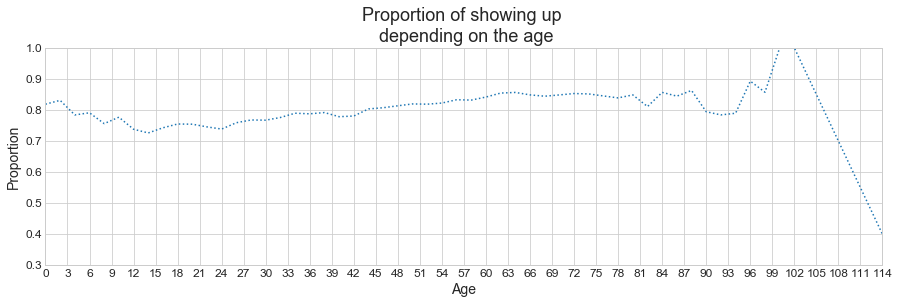

In [32]:
#plot
x_ticks = np.arange(0, 115, 3)
y_ticks = np.arange(0.3, 10, 0.1)
age_prop.plot(figsize=(15,4), style=':', ylim=[0.3, 1], xticks=x_ticks, yticks=y_ticks, fontsize=12)
plt.title('Proportion of showing up \n depending on the age', fontsize=18)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Proportion', fontsize=14);

The age of the patient seems to have a impact on the showing-up proportion. Patient between 0 and 3 years old and older age (from 43 to 93 years old) are coming to appointment in around 80-85% of case. The in-between ages are less coming with a decrease of nearly 8%. Patient from 93 years old to 99 years are strongly coming to appointment within a range of 80 to 100% of cases. The curve over 99 years old can be analyzed due to too few patients (11, see below)

In [33]:
(df.query('Age > 99')).count()['AppointmentID']

11

<a id='period'></a>
### Q3: Does the period between the appointment date and the scheduled day make a difference in the coming rate?

In [34]:
#getting the proportion of showing up with helper function
waiting_prop = come_prop('waiting_period')

In [36]:
#plot
fig, ax = plt.subplots(figsize=(14,6))
x_graph = df['waiting_period'].unique() #the values of waiting  period
y_graph = waiting_prop 
ax.scatter(x_graph, y_graph, s=30, color='c')
ax.set_title('Proportion of showing up \n depending on the waiting period', fontsize=18)
ax.set_xlabel('Waiting period (days)', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.set_yticks(np.arange(min(y_graph), max(y_graph)+0.1, 0.05))
ax.set_xticks(np.arange(min(x_graph), max(x_graph)+1, 5));


The period that the patient has to wait between the scheduling and the appointment seems to play a role in the fact of coming or not. If the patient has the appointment immediately, the proportion of coming is 95%. Then the pourcentage of coming is dropping to 77% if the waiting is 0 to 5 days. From 2 days to 75 days (2 months and half) the pourcentage of coming is decreasing from 77% to 60%. It seems that there is negative correlation. After 2 months and half (75 days) there is a large heterogeneity.

**Vizualise the correlation between the proportion of showing up and the waiting period between 2 days and 75 days** <br> We will perform a linear regression and then use a line plot to see it with the 95% confidence interval.

In [37]:
#perform linear regression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

#get the values for x
sorted_x_graph = sorted(df['waiting_period'].unique())
x_value = sorted_x_graph[2: 76]
#regression
x = sm.add_constant(x_value)
y = y_graph[2:76]
regr = sm.OLS(y, x)
res = regr.fit()
# Get fitted values from model to plot
st, data, ss2 = summary_table(res, alpha=0.05)
fitted_values = data[:,2]

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [38]:
# Get the confidence intervals of the model
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

# Data for regions where we want to shade to indicate the intervals has
# to be sorted by the x axis to display correctly
CI_df = pd.DataFrame(columns = ['x_data', 'low_CI', 'upper_CI'])
CI_df['x_data'] = x_value
CI_df['low_CI'] = predict_mean_ci_low
CI_df['upper_CI'] = predict_mean_ci_upp
CI_df.sort_values('x_data', inplace = True)

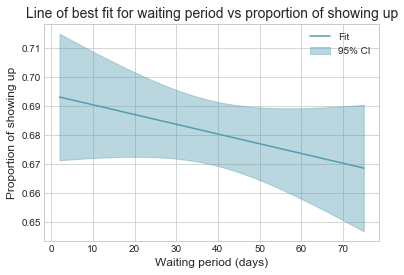

In [39]:
# Create the plot
f, ax = plt.subplots()

# Plot the best fit line
ax.plot(x_value, fitted_values, color = '#539caf', label='Fit')

# Shade the confidence interval
ax.fill_between(CI_df['x_data'], CI_df['low_CI'], CI_df['upper_CI'], color = '#539caf', alpha = 0.4, label = '95% CI')

#set the axes and title
ax.set_title('Line of best fit for waiting period vs proportion of showing up', fontsize=14)
ax.set_xlabel('Waiting period (days)', fontsize=12)
ax.set_ylabel('Proportion of showing up', fontsize=12)

# Display legend
ax.legend(loc = 'best');

<a id='day'></a>
### Q4: Does the day of the meeting make a difference?

In [40]:
#getting the proportion of showing up with helper function
week_prop = come_prop('day_of_week')
week_prop

day_of_week
Friday       0.787739
Monday       0.793554
Saturday     0.769231
Thursday     0.806506
Tuesday      0.799126
Wednesday    0.803139
Name: AppointmentID, dtype: float64

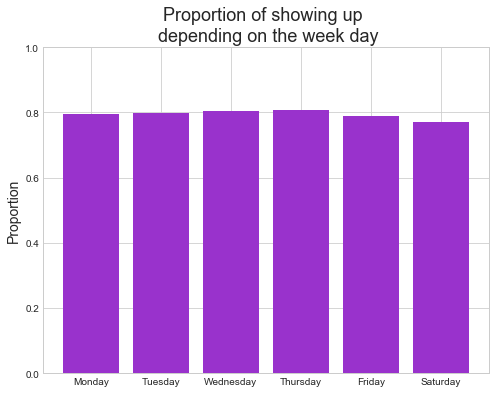

In [41]:
#order the week_prop in the order we want
#Remind: No appointment happens en Sunday
data_y = [] #the stock the week_prop
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
for element in order:
    data_y.append(week_prop[element])

#plot
fig, ax = plt.subplots(figsize=(8,6))
tick_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.bar(np.arange(6), data_y, tick_label=tick_name, color='darkorchid' )
ax.set_ylim([0, 1])
plt.title('Proportion of showing up \n depending on the week day', fontsize=18)
plt.xlabel('')
plt.ylabel('Proportion', fontsize=14)
plt.show();


Along the week, patients are coming at the same proportion. There is a slight drop at the end of the week, however it might not be statistical significant.

<a id='text'></a>
### Q5: Does reminding the appointment with a text make a higher rate of coming?

In [42]:
#getting the proportion of showing up with helper function
SMS_prop = come_prop('SMS_received')
SMS_prop

SMS_received
0    0.833020
1    0.724255
Name: AppointmentID, dtype: float64

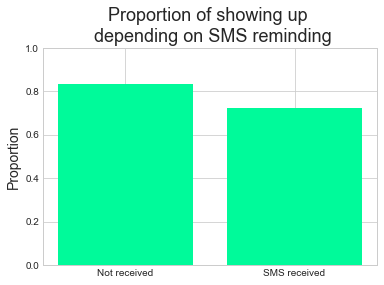

In [44]:
#plot
fig, ax = plt.subplots(figsize=(6,4))
tick_name= ['Not received', 'SMS received']
plt.bar(np.arange(2), SMS_prop, tick_label=tick_name, color='mediumspringgreen' )
ax.set_ylim([0, 1])
plt.title('Proportion of showing up \n depending on SMS reminding', fontsize=18)
plt.xlabel('')
plt.ylabel('Proportion', fontsize=14)
plt.show();

Patients who were reminding the appointment with a text are coming at 72% of cases. This is lower than patient without reminding.

<a id='conclusions'></a>
## Conclusions

From this analysis we can conclude that some parameters seem to influence if patients are coming, while others have no impact. <br><br>We have observed that a chronic disease is not a condition for patients to come a lot more. Even in the case of handicap, the more handicap there is, the less the patient is coming. However in the database few patients with strong handicap (stage 3 or 4) are represented and a further study would be needed.
<br> Another parameter which is not influencing the coming rate is the day of the week. 
<br> <br>
The parameters of age and waiting period seem to have impact on coming. <br>
Patients at really young age (0-3 years old) and older adult (43-93 year) are more coming than middle-aged patients. One explanations for really young age is that baby has to come with parents. Moreover, we might be more worried and go to hospital if a baby is sick than a older child or teenager. We have olso observed that patient from 93 years old to 99 years are strongly coming to appointment (from 80% to 100% of cases). At this age, a disease is strongly dangerous for survival and this range of age might has an large importance for coming. <br>
The waiting time seems to play a big role in the coming rate. The more patient waits, the less he is inclined to come. There might be two explanations. First with the time, maybe the disease is gone or cured and the patient is no more coming without canceling the appointment. A complementary study with specification of the type of disease could be interesting. Second, another explanation is that with time the patient could have forget the appointment. <br>
However we have observed that reminding the appointment by SMS is not impacting the coming rate. It seems to even lead to decrease of 10%. The second explanation for the waiting period is thus not so plausible. <br>
An interesting fact is that reminding by SMS is not increasing the coming rate. Hospitals are paying for this service, which seems to not fix the issue of the patients who are not coming. <br><br>
All these analysis should be viewed cautiously because for the moment no statistical analysis have been done.


<a id='references'></a>
## References
For this project, I have been inspired for the waiting period by the __[kernel](https://www.kaggle.com/jfgobin/basic-visualisation-and-prediction)__ of Jean-François Gobin. For the linear regression, I used helped of the blog post from __[DataScience.com](https://www.datascience.com/blog/learn-data-science-intro-to-data-visualization-in-matplotlib)__.